In [1]:
%cd ..
%env CUDA_VISIBLE_DEVICES=1

/mnt/SSD/lengx/REPA
env: CUDA_VISIBLE_DEVICES=1


In [2]:
import torch
import random
from utils import load_encoders
from models.sit import SiT_models
from diffusers import AutoencoderKL
import torch.nn.functional as F
import json
import numpy as np
import h5py
import os
import PIL
import gc
import io
from torchvision.transforms import Normalize
from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
import matplotlib.pyplot as plt
from tqdm import tqdm
from metrics import AlignmentMetrics

pyspng = None

Please install the pymp library using `pip install pymp` to speed up non-batched metrics


In [3]:
### Prepare the data
with open("data/images_h5.json", "r") as f:
    images_h5_cfg = json.load(f)
with open("data/vae-sd_h5.json", "r") as f:
    vae_h5_cfg = json.load(f)

def load_h5_file(hf, path):
    # Helper function to load files from h5 file
    if path.endswith('.png'):
        if pyspng is not None:
            rtn = pyspng.load(io.BytesIO(np.array(hf[path])))
        else:
            rtn = np.array(PIL.Image.open(io.BytesIO(np.array(hf[path]))))
        rtn = rtn.reshape(*rtn.shape[:2], -1).transpose(2, 0, 1)
    elif path.endswith('.json'):
        rtn = json.loads(np.array(hf[path]).tobytes().decode('utf-8'))
    elif path.endswith('.npy'):
        rtn= np.array(hf[path])
    else:
        raise ValueError('Unknown file type: {}'.format(path))
    return rtn

def preprocess_raw_image(x, enc_type):
    x = x / 255.
    x = Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD)(x)
    x = torch.nn.functional.interpolate(x, 224, mode='bicubic')
    x = torch.nn.functional.interpolate(x, 224, mode='bicubic')
    return x

N = 256
BS = 8
chosen_files = random.Random(42).sample(images_h5_cfg, N)
chosen_vaes = [elem.replace("img", "img-mean-std-").replace(".png", ".npy") for elem in chosen_files]

image_h5 = h5py.File("data/images.h5", "r")
vae_h5 = h5py.File("data/vae-sd.h5", "r")

### Labels...
fname = 'dataset.json'
labels = load_h5_file(vae_h5, fname)['labels']
labels = dict(labels)
labels = [labels[fname.replace('\\', '/')] for fname in chosen_vaes]
labels = np.array(labels)
labels = labels.astype({1: np.int64, 2: np.float32}[labels.ndim])

images = preprocess_raw_image(torch.stack([torch.from_numpy(load_h5_file(image_h5, elem)) for elem in chosen_files]), "dinov2-vit-b")
vaes = torch.stack([torch.from_numpy(load_h5_file(vae_h5, elem)) for elem in chosen_vaes])
labels = torch.from_numpy(labels)

In [ ]:
### Load external visual model, and extract features
encoders, encoder_types, architectures = load_encoders("dinov2-vit-b", "cuda:0")
# encoders, encoder_types, architectures = load_encoders("dinov2-vit-l", "cuda:0")
# encoders, encoder_types, architectures = load_encoders("dinov2-vit-g", "cuda:0")

encoder, encoder_type, architecture = encoders[0], encoder_types[0], architectures[0]
# vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse").to("cuda:0")

zs = []
for i in tqdm(range(0, N, BS)):
    images_batch = preprocess_raw_image(images[i:i+BS].to("cuda:0"), encoder_type)
    with torch.no_grad():
        z = encoder.forward_features(images_batch)['x_norm_patchtokens']
        zs.append(z)
zs = torch.cat(zs, dim=0).cpu()


# NOTE: The model checkpoints we are interested in
ckpt_paths = [
    "exps/sit-b-base-400k/checkpoints", "exps/sit-b-linear-dinov2-b-enc8-400k/checkpoints",
    "exps/sit-b-linear-dinov2-b-enc8-patch-0.5-400k/checkpoints", "exps/sit-b-linear-dinov2-b-enc8-patch-0.75-400k/checkpoints",
]
model_name = "SiT-B/2"

# ckpt_paths = ["exps/sit-xl-base-400k/checkpoints", "exps/sit-xl-linear-dinov2-b-enc8-400k/checkpoints"]
# model_name = "SiT-XL/2"

# ckpt_paths = ["pretrained_models"]
# model_name = "SiT-XL/2"


### Model HPs
resolution = 256
num_classes = 1000
assert resolution % 8 == 0
latent_size = resolution // 8
# z_dims = [encoder.embed_dim for encoder in encoders]
z_dims = [768]
encoder_depth = 8
block_kwargs = {"fused_attn": False, "qk_norm": False}


def get_model(ckpt_path):
    model = SiT_models[model_name](
        latent_size=latent_size,
        num_classes=num_classes,
        use_cfg=True,
        z_dims=z_dims,
        encoder_depth=encoder_depth,
        **block_kwargs,
    ).to("cuda:0")
    state_dict = torch.load(ckpt_path, map_location="cuda:0")
    if "model" in state_dict:
        state_dict = state_dict["model"]
    model.load_state_dict(state_dict)
    model.eval()
    return model

def interpolant(t):
    alpha_t = 1 - t
    sigma_t = t
    d_alpha_t = -1
    d_sigma_t = 1
    return alpha_t, sigma_t, d_alpha_t, d_sigma_t

def mean_flat(x):
    return torch.mean(x, dim=list(range(1, len(x.size()))))

@torch.no_grad()
def sample_posterior(moments, latents_scale=1., latents_bias=0.):
    mean, std = torch.chunk(moments, 2, dim=1)
    z = mean + std * torch.randn_like(mean)
    z = (z * latents_scale + latents_bias) 
    return z

latents_scale = torch.tensor(
    [0.18215, 0.18215, 0.18215, 0.18215]
).view(1, 4, 1, 1).to("cuda:0")
latents_bias = torch.tensor(
    [0., 0., 0., 0.]
).view(1, 4, 1, 1).to("cuda:0")

Using cache found in /home/lengx/.cache/torch/hub/facebookresearch_dinov2_main
/home/lengx/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/lengx/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/lengx/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
100%|██████████| 32/32 [00:14<00:00,  2.26it/s]


In [5]:
ckpt_stats = {}

for ckpt_path in ckpt_paths:
    # stats_neg_cos_sim = {}
    # stats_frobenius_l2_norm = {}
    stats_cknna_align = {}
    stats_mutual_knn = {}

    for elem in sorted(os.listdir(ckpt_path)):
        model = get_model(os.path.join(ckpt_path, elem))

        # Call gc
        gc.collect()
        torch.cuda.empty_cache()

        zs_tilde = []
        for i in tqdm(range(0, N, BS)):
            vaes_batch = vaes[i:i+BS].to("cuda:0")
            labels_batch = labels[i:i+BS].to("cuda:0")
            x = sample_posterior(vaes_batch, latents_scale=latents_scale, latents_bias=latents_bias)
            model_kwargs = dict(y = labels_batch)
            # time_input = torch.rand((x.shape[0], 1, 1, 1), device="cuda:0", dtype=x.dtype)
            time_input = torch.rand((x.shape[0], 1, 1, 1), device="cuda:0", dtype=x.dtype)
            # time_input = torch.fill_(torch.zeros((x.shape[0], 1, 1, 1), device="cuda:0", dtype=x.dtype), 0.5)  # <--- control on time

            noises = torch.randn_like(x)
            alpha_t, sigma_t, d_alpha_t, d_sigma_t = interpolant(time_input)  # linear

            model_input = alpha_t * x + sigma_t * noises
            model_target = d_alpha_t * x + d_sigma_t * noises

            with torch.no_grad():
                model_output, z_tilde = model.forward_features(model_input, time_input.flatten(), **model_kwargs)
                # zs_tilde.append(z_tilde[0])
                zs_tilde.append(z_tilde)
        zs_tilde = torch.cat(zs_tilde, dim=0)

        cknna_align = []
        mutual_knn_align = []
        for l in range(zs_tilde.shape[1]):
            # CKNNA method for alignment
            # print(zs_tilde[:, l].mean(dim=1).shape)
            # print(zs.mean(dim=1).shape)
            # break
            cknna = AlignmentMetrics.cknna(zs.mean(dim=1), zs_tilde[:, l].mean(dim=1), topk=10)
            mutual_knn = AlignmentMetrics.mutual_knn(zs.mean(dim=1), zs_tilde[:, l].mean(dim=1), topk=10)
            cknna_align.append(cknna)
            mutual_knn_align.append(mutual_knn)

        step = int(elem[:-3]) if "last.pt" not in elem else 7_000_000
        stats_cknna_align[step] = cknna_align
        stats_mutual_knn[step] =  mutual_knn_align

    ckpt_stats[ckpt_path] = {"cknna_align": stats_cknna_align, "mutual_knn": stats_mutual_knn}
    # ckpt_stats[ckpt_path] = {"neg_cos_sim": stats_neg_cos_sim, "kernel_align_patch_l2": stats_frobenius_l2_norm, "cknna_align": stats_cknna_align, "mutual_knn": stats_mutual_knn}

100%|██████████| 32/32 [00:02<00:00, 14.12it/s]


In [6]:
print(ckpt_stats.keys())
print(ckpt_stats[ckpt_paths[0]].keys())
print(ckpt_stats[ckpt_paths[0]]["cknna_align"].keys())

dict_keys(['exps/sit-b-base-400k/checkpoints', 'exps/sit-b-linear-dinov2-b-enc8-400k/checkpoints', 'exps/sit-b-linear-dinov2-b-enc8-patch-0.5-400k/checkpoints', 'exps/sit-b-linear-dinov2-b-enc8-patch-0.75-400k/checkpoints'])
dict_keys(['cknna_align', 'mutual_knn'])
dict_keys([50000, 100000, 150000, 200000, 250000])


In [9]:
if ckpt_paths[0] == "pretrained_models":
    plt.figure(figsize=(10, 5))
    plt.plot(np.array(range(len(cknna_align))) + 1, cknna_align, label="CKNNA",marker='o')
    plt.plot(np.array(range(len(cknna_align))) + 1, mutual_knn_align, label="Mutual KNN", marker='x')
    plt.xlabel("Layer")
    plt.ylabel("Alignment score")
    plt.title("Alignment metrics for SiT-XL/2 model @ 7M steps")
    plt.xticks(np.array(range(len(cknna_align))) + 1)
    plt.ylim(0, 0.5)
    plt.legend()
    plt.show()

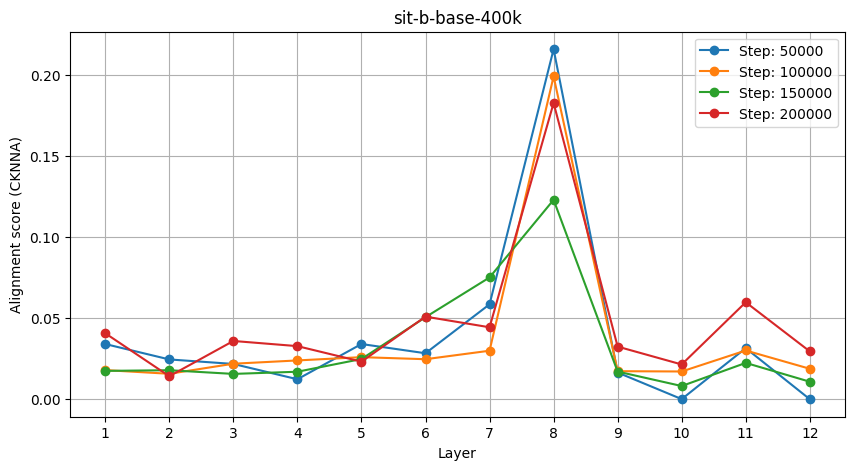

In [12]:
### 3 plots for Figure 2 in the paper

# k = "exps/sit-b-base-400k/checkpoints"
k = "exps/sit-b-linear-dinov2-b-enc8-400k/checkpoints"

if k in ckpt_paths:
    plt.figure(figsize=(10, 5))
    for step, align in ckpt_stats[k]["cknna_align"].items():
        plt.plot(np.array(range(len(align))) + 1, align, label=f"Step: {step}", marker='o')
    plt.xlabel("Layer")
    plt.ylabel("Alignment score (CKNNA)")
    plt.title("sit-b-base-400k")
    plt.xticks(np.array(range(len(align))) + 1)
    plt.grid()
    plt.legend()
    plt.show()
    

# if "exps/sit-b-linear-dinov2-b-enc8-400k/checkpoints" in ckpt_paths:
#     plt.figure(figsize=(10, 5))
#     for step, align in ckpt_stats["exps/sit-b-linear-dinov2-b-enc8-400k/checkpoints"]["cknna_align"].items():
#         plt.plot(np.array(range(len(align))) + 1, align, label=f"Step: {step}", marker='o')
#     plt.xlabel("Layer")
#     plt.ylabel("Alignment score (CKNNA)")
#     plt.title("sit-b-linear-dinov2-b-enc8-400k")
#     plt.xticks(np.array(range(len(align))) + 1)
#     plt.grid()
#     plt.legend()
#     plt.show()



---------------------------